In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.stats import wilcoxon, ttest_ind, ttest_rel
import pandas as pd
import os
import typing as tp
from explanatory_analysis import SpDataCleaner
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

In [2]:
df_rf_params = pd.read_csv('reports/5_20.0/best_params_rf_5.0_20.0.csv')
df_rf_params.rename(columns={'Unnamed: 0': 'Model'}, inplace=True)
df_rf_params.columns

Index(['Model', 'n_estimators', 'min_samples_split', 'min_samples_leaf',
       'max_depth', 'criterion', 'bootstrap'],
      dtype='object')

In [3]:
spdc = SpDataCleaner()
spdc.to_dummies()
moco_survey = spdc.df
X = moco_survey.drop(['choice','ResponseId'], axis=1)
y = moco_survey['choice']

In [4]:
def rq_3_improved_performance_rf(df,models:tp.List[str]):
    
    dict_models = {} 
    
    for model in models:
        random.seed(42)
        np.random.seed(42)
        MRF = []
        
        df_mrf = df[df['Model'] == model]
        max_depth = df_mrf['max_depth'].values[0]
        if str(max_depth) == 'nan':
            max_depth = None
        else:
            max_depth = int(max_depth)
        rf = RandomForestClassifier(n_estimators=df_mrf['n_estimators'].values[0], max_depth=max_depth,min_samples_split=df_mrf['min_samples_split'].values[0], min_samples_leaf=df_mrf['min_samples_leaf'].values[0], criterion=df_mrf['criterion'].values[0], bootstrap=df_mrf['bootstrap'].values[0], random_state=42)
        
    
    
        if model == 'M1RF':
            kfold = KFold(n_splits=10, shuffle=True, random_state=42)
            
            for train_val_index, test_index in kfold.split(X):
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.11, random_state=42)
                rf.fit(X_train, y_train)
                y_pred = rf.predict(X_test)
                MRF.append(accuracy_score(y_test, y_pred))  
            dict_models[model] = MRF
        
        elif model =='M7RF':
            
            kfold = KFold(n_splits=10, shuffle=True, random_state=42)
            for train_val_index, test_index in kfold.split(X, groups=moco_survey['ResponseId']):
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                
                rf.fit(X_train_val, y_train_val)
                y_pred = rf.predict(X_test)
                 
                MRF.append(accuracy_score(y_test, y_pred))  
            dict_models[model] = MRF
            
        elif model == 'M3RF':
            group_fold = GroupKFold(n_splits=10)
            for train_val_index, test_index in group_fold.split(X, groups=moco_survey['ResponseId']):
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.11, random_state=42)
                rf.fit(X_train, y_train)
                y_pred = rf.predict(X_test)
                MRF.append(accuracy_score(y_test, y_pred))   
            dict_models[model] = MRF
            
        elif model == 'M9RF':
            group_fold = GroupKFold(n_splits=10)
            for train_val_index, test_index in group_fold.split(X, groups=moco_survey['ResponseId']):
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                rf.fit(X_train_val, y_train_val)
                y_pred = rf.predict(X_test)
                MRF.append(accuracy_score(y_test, y_pred))
            dict_models[model] = MRF
            
        elif model == 'M11RF':
            group_fold_1 = GroupKFold(n_splits=10)
            for train_val_index, test_index in group_fold_1.split(X, groups=moco_survey['ResponseId']):
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                
                avg_acc = []
                group_fold_2 = GroupKFold(n_splits=9)
                for train_index, val_index in group_fold_2.split(X_train_val, groups=moco_survey['ResponseId'].iloc[train_val_index]):
                    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
                    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
                    rf.fit(X_train, y_train)
                    y_pred = rf.predict(X_test)
                    avg_acc.append(accuracy_score(y_test, y_pred))
                    
                MRF.append(np.mean(avg_acc))
            dict_models[model] = MRF
            
        
        elif model == 'M5RF':
            
            group_fold_1 = GroupKFold(n_splits=10)
            for train_val_index, test_index in group_fold_1.split(X, groups=moco_survey['ResponseId']):
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                
                #avg_acc = []
                group_fold_2 = GroupKFold(n_splits=9)
                for train_index, val_index in group_fold_2.split(X_train_val, groups=moco_survey['ResponseId'].iloc[train_val_index]):
                    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
                    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
                    rf.fit(X_train, y_train)
                    y_pred = rf.predict(X_test)
                    #avg_acc.append(accuracy_score(y_val, y_pred))
                    MRF.append(accuracy_score(y_test, y_pred))
                    break    
            dict_models[model] = MRF
            
    return pd.DataFrame(dict_models)
    

In [5]:
df = rq_3_improved_performance_rf(df_rf_params, ['M11RF', 'M3RF', 'M5RF', 'M7RF', 'M9RF', 'M1RF'])
df.describe()

Running model M11RF
M11RF :10
Running model M3RF
M3RF :10
Running model M5RF
M5RF :10
Running model M7RF
M7RF :10
Running model M9RF
M9RF :10
Running model M1RF
M1RF :10


,M11RF,M3RF,M5RF,M7RF,M9RF,M1RF
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.590379,0.584220,0.590707,0.755622,0.582175,0.747839
std,0.026139,0.024752,0.025428,0.008722,0.022761,0.007139
min,0.538272,0.541358,0.541358,0.744287,0.543210,0.736257
25%,0.583162,0.577932,0.577623,0.748339,0.571914,0.743823
50%,0.596262,0.590123,0.595062,0.756331,0.589506,0.747915
75%,0.610335,0.602160,0.606790,0.761272,0.598457,0.749228
max,0.618244,0.613806,0.622222,0.771941,0.610494,0.760198


In [6]:
p_values = {}
p_values['M7RF vs M1RF'] = wilcoxon(df['M7RF']*100, df['M1RF']*100,alternative='greater').pvalue
p_values['M9RF vs M3RF'] = wilcoxon(df['M9RF']*100, df['M3RF']*100,alternative='greater').pvalue
p_values['M11RF vs M5RF'] = wilcoxon(df['M11RF']*100, df['M5RF']*100,alternative='greater').pvalue
p_values


{'M7RF vs M1RF': 0.0029296875,
 'M9RF vs M3RF': 0.8388671875,
 'M11RF vs M5RF': 0.615234375}

C:\Users\berha\AppData\Local\Temp\ipykernel_22660\64271838.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


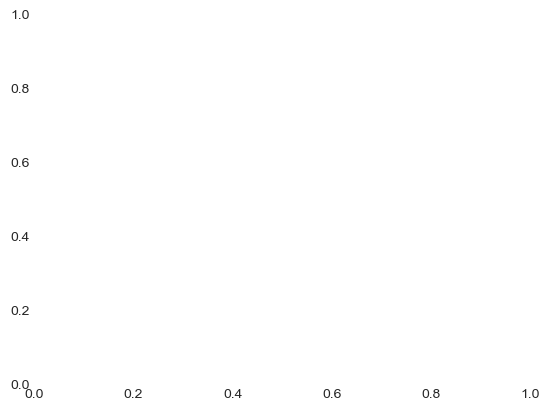

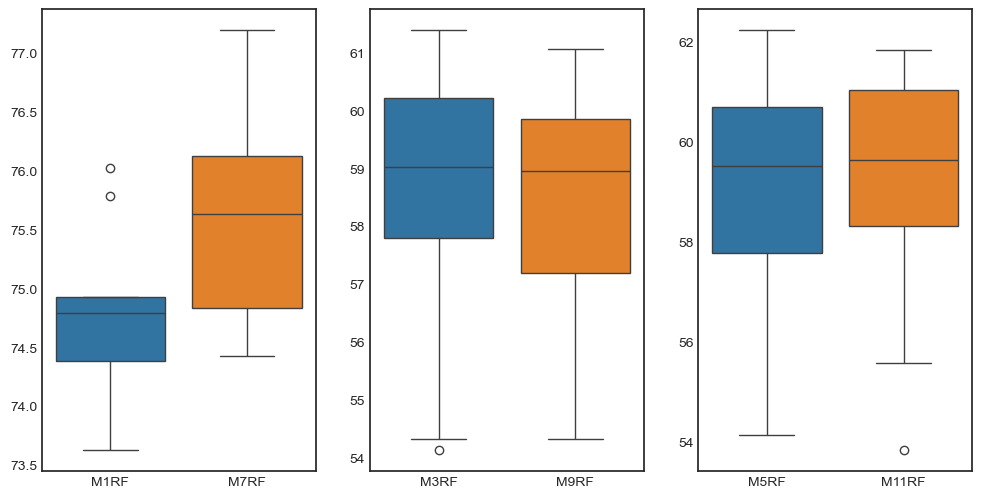

In [7]:
plt.style.use('seaborn-white')
plt.box(False)
fig, ax = plt.subplots(1,3, figsize=(12,6))

sns.boxplot(data=df[['M1RF', 'M7RF']]*100, ax=ax[0])
sns.boxplot(data=df[['M3RF', 'M9RF']]*100, ax=ax[1])
sns.boxplot(data=df[['M5RF', 'M11RF']]*100, ax=ax[2])

plt.savefig('plots/RQ3/boxplot_rf_oos.png')

C:\Users\berha\AppData\Local\Temp\ipykernel_22660\1709516836.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


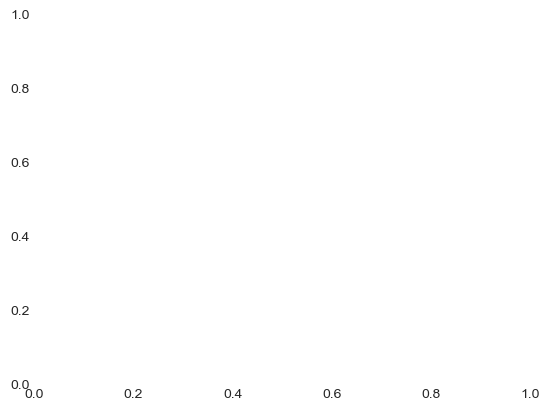

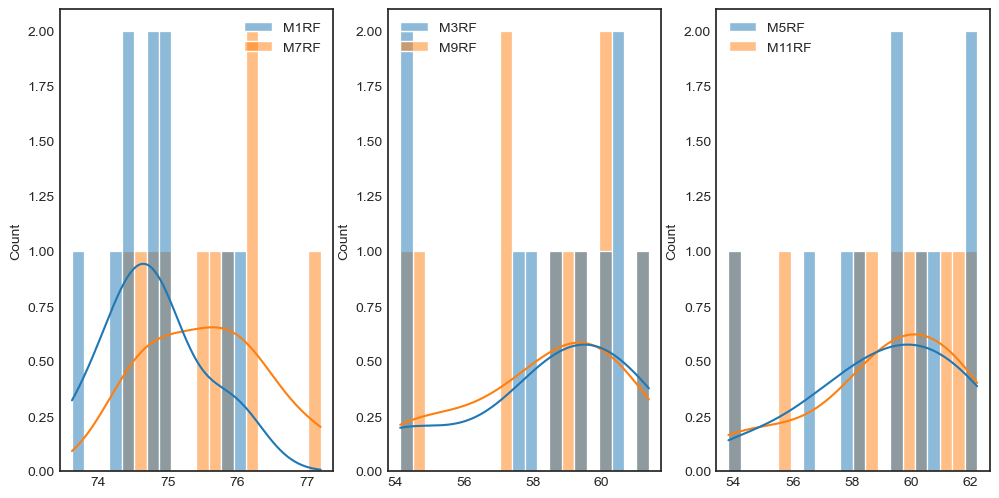

In [8]:
plt.style.use('seaborn-white')
plt.box(False)
fig, ax = plt.subplots(1,3, figsize=(12,6))
sns.histplot(data=df[['M1RF', 'M7RF']]*100, ax=ax[0],bins=20,kde=True)
sns.histplot(data=df[['M3RF', 'M9RF']]*100, ax=ax[1],bins=20,kde=True)
sns.histplot(data=df[['M5RF', 'M11RF']]*100, ax=ax[2],bins=20,kde=True)

plt.savefig('plots/RQ3/hist_rf_oos.png')

In [9]:
t_p_values = {}
t_p_values['M7RF vs M1RF'] = ttest_rel(df['M7RF'], df['M1RF']).pvalue
t_p_values['M9RF vs M3RF'] = ttest_rel(df['M9RF'], df['M3RF']).pvalue
t_p_values['M11RF vs M5RF'] = ttest_rel(df['M11RF'], df['M5RF']).pvalue
t_p_values

{'M7RF vs M1RF': 0.003040849784417362,
 'M9RF vs M3RF': 0.31379947772439254,
 'M11RF vs M5RF': 0.8774105551419432}

In [10]:
df_ann_params = pd.read_csv('reports/5_20.0/best_params_ann_5.0_20.0.csv')
df_ann_params.rename(columns={'Unnamed: 0': 'Model'}, inplace=True)
df_ann_params

,Model,n_hidden_layers,n_neurons,learning_rate,batch_size,n_epochs,dropout
0,M1ANN,2,128,0.010,500,25,0.30
1,M2ANN,2,128,0.010,500,25,0.30
2,M3ANN,2,256,0.001,500,45,0.00
3,M4ANN,3,32,0.001,128,60,0.15
4,M5ANN,1,256,0.010,128,60,0.30
5,M6ANN,1,64,0.001,1000,100,0.50
6,M7ANN,3,256,0.010,500,60,0.00
7,M8ANN,3,32,0.001,128,60,0.15
8,M9ANN,3,256,0.010,500,60,0.00
9,M10ANN,3,32,0.001,128,60,0.15


In [11]:
def rq_3_improved_performance_ann(df_params: pd.DataFrame,models: tp.List[str]):
    
    dict_models = {}
    
    for model in models:
        random.seed(42)
        np.random.seed(42)
        tf.random.set_seed(42)
        print(f'Running model {model}')
        MANN = []
        
        df_mann = df_params[df_params['Model'] == model]
        dropout = df_mann['dropout'].values[0]
        n_hidden_layers = df_mann['n_hidden_layers'].values[0]
        n_neurons = df_mann['n_neurons'].values[0]
        learning_rate = df_mann['learning_rate'].values[0]
        batch_size = df_mann['batch_size'].values[0]
        n_epochs = df_mann['n_epochs'].values[0]
        
        if model == 'M1ANN':
            
            kfold = KFold(n_splits=10, shuffle=True, random_state=42)
            for train_val_index, test_index in kfold.split(X):
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.11, random_state=42)
                scaler = StandardScaler()
                X_train = X_train.values
                X_train = scaler.fit_transform(X_train)
                X_val = X_val.values
                X_val = scaler.transform(X_val)
                X_test = X_test.values
                X_test = scaler.transform(X_test)
                ann = Sequential()
                ann.add(Dense(63, activation='relu'))
                ann.add(Dropout(dropout,seed=42))
                for _ in range(n_hidden_layers):
                    ann.add(Dense(n_neurons, activation='relu'))
                    ann.add(Dropout(dropout,seed=42))
                ann.add(Dense(8, activation='softmax'))
                
                ann.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                ann.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0, callbacks=[EarlyStopping(patience=10,monitor ='accuracy',mode='max')],validation_data=(X_val, y_val))
                
                y_pred = np.argmax(ann.predict(X_test), axis=-1)
                MANN.append(accuracy_score(y_test, y_pred))
            dict_models[model] = MANN
            
        elif model == 'M7ANN':
            kfold = KFold(n_splits=10, shuffle=True, random_state=42)
            for train_val_index, test_index in kfold.split(X):
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                
                
                scaler = StandardScaler()
                X_train_val = X_train_val.values
                X_train_val = scaler.fit_transform(X_train_val)
                X_test = X_test.values
                X_test = scaler.transform(X_test)
                ann = Sequential()
                ann.add(Dense(63, activation='relu'))
                ann.add(Dropout(dropout,seed=42))
                for _ in range(n_hidden_layers):
                    ann.add(Dense(n_neurons, activation='relu'))
                    ann.add(Dropout(dropout,seed=42))
                ann.add(Dense(8, activation='softmax'))
                
                ann.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                ann.fit(X_train_val, y_train_val, batch_size=batch_size, epochs=n_epochs, verbose=0, callbacks=[EarlyStopping(patience=10,monitor ='accuracy',mode='max')])
                
                y_pred = np.argmax(ann.predict(X_test), axis=-1)
                MANN.append(accuracy_score(y_test, y_pred))   
            dict_models[model] = MANN
            
            
        elif model == 'M3ANN':
            
            group_fold = GroupKFold(n_splits=10)
            for train_val_index, test_index in group_fold.split(X, groups=moco_survey['ResponseId']):
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.11, random_state=42)
                scaler = StandardScaler()
                X_train = X_train.values
                X_train = scaler.fit_transform(X_train)
                X_val = X_val.values
                X_val = scaler.transform(X_val)
                X_test = X_test.values
                X_test = scaler.transform(X_test)
                ann = Sequential()
                ann.add(Dense(63, activation='relu'))
                ann.add(Dropout(dropout,seed=42))
                for _ in range(n_hidden_layers):
                    ann.add(Dense(n_neurons, activation='relu'))
                    ann.add(Dropout(dropout,seed=42))
                ann.add(Dense(8, activation='softmax'))
                
                ann.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                ann.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0, callbacks=[EarlyStopping(patience=10,monitor ='accuracy',mode='max')],validation_data=(X_val, y_val))
                
                y_pred = np.argmax(ann.predict(X_test), axis=-1)
                MANN.append(accuracy_score(y_test, y_pred))   
            dict_models[model] = MANN
            
        elif model == 'M9ANN':
            
            group_fold = GroupKFold(n_splits=10)
            for train_val_index, test_index in group_fold.split(X, groups=moco_survey['ResponseId']):
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                
                scaler = StandardScaler()
                X_train_val = X_train_val.values
                X_train_val = scaler.fit_transform(X_train_val)
                X_test = X_test.values
                X_test = scaler.transform(X_test)
                ann = Sequential()
                ann.add(Dense(63, activation='relu'))
                ann.add(Dropout(dropout,seed=42))
                for _ in range(n_hidden_layers):
                    ann.add(Dense(n_neurons, activation='relu'))
                    ann.add(Dropout(dropout,seed=42))
                ann.add(Dense(8, activation='softmax'))
                
                ann.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                ann.fit(X_train_val, y_train_val, batch_size=batch_size, epochs=n_epochs, verbose=0, callbacks=[EarlyStopping(patience=10,monitor ='accuracy',mode='max')])
                
                y_pred = np.argmax(ann.predict(X_test), axis=-1)
                MANN.append(accuracy_score(y_test, y_pred))
            dict_models[model] = MANN
            
        elif model == 'M11ANN':
            
            group_fold_1 = GroupKFold(n_splits=10)
            for train_val_index, test_index in group_fold_1.split(X, groups=moco_survey['ResponseId']):
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                
                avg_acc = []
                group_fold_2 = GroupKFold(n_splits=9)
                for train_index, val_index in group_fold_2.split(X_train_val, groups=moco_survey['ResponseId'].iloc[train_val_index]):
                    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
                    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
                    scaler = StandardScaler()
                    x_train = X_train.values
                    x_train = scaler.fit_transform(x_train)
                    x_val = X_val.values
                    x_val = scaler.transform(x_val)
                    x_test = X_test.values
                    x_test = scaler.transform(x_test)
                    ann = Sequential()
                    ann.add(Dense(63, activation='relu'))
                    ann.add(Dropout(dropout,seed=42))
                    for _ in range(n_hidden_layers):
                        ann.add(Dense(n_neurons, activation='relu'))
                        ann.add(Dropout(dropout,seed=42))
                    ann.add(Dense(8, activation='softmax'))
                    
                    ann.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                    ann.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0, callbacks=[EarlyStopping(patience=10,monitor ='val_accuracy',mode='max')],validation_data=(x_val, y_val))
                    
                    y_pred = np.argmax(ann.predict(x_test), axis=-1)
                    avg_acc.append(accuracy_score(y_test, y_pred))
                    
                MANN.append(np.mean(avg_acc))   
            dict_models[model] = MANN
        
        elif model == 'M5ANN':
            
            group_fold_1 = GroupKFold(n_splits=10)
            for train_val_index, test_index in group_fold_1.split(X, groups=moco_survey['ResponseId']):
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                
                
                group_fold_2 = GroupKFold(n_splits=9)
                for train_index, val_index in group_fold_2.split(X_train_val, groups=moco_survey['ResponseId'].iloc[train_val_index]):
                    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
                    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
                    scaler = StandardScaler()
                    x_train = X_train.values
                    x_train = scaler.fit_transform(x_train)
                    x_val = X_val.values
                    x_val = scaler.transform(x_val)
                    x_test = X_test.values
                    x_test = scaler.transform(x_test)
                    ann = Sequential()
                    ann.add(Dense(63, activation='relu'))
                    ann.add(Dropout(dropout,seed=42))
                    for _ in range(n_hidden_layers):
                        ann.add(Dense(n_neurons, activation='relu'))
                        ann.add(Dropout(dropout,seed=42))
                    ann.add(Dense(8, activation='softmax'))
                    
                    ann.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                    ann.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0, callbacks=[EarlyStopping(patience=10,monitor ='val_accuracy',mode='max')],validation_data=(x_val, y_val))
                    
                    y_pred = np.argmax(ann.predict(x_test), axis=-1)
                    
                    MANN.append(accuracy_score(y_test, y_pred))
                    break   
            dict_models[model] = MANN
            
    return pd.DataFrame(dict_models)  
    

In [12]:
df = rq_3_improved_performance_ann(df_ann_params, ['M11ANN', 'M5ANN', 'M3ANN', 'M7ANN', 'M9ANN', 'M1ANN'])

Running model M11ANN
51/51 [==============================] - 0s 2ms/step
M11ANN :[0.5561042524005486, 0.5732510288065844, 0.5474622770919066, 0.6248285322359397, 0.6006172839506172, 0.6196159122085049, 0.5871056241426612, 0.60960219478738, 0.6063100137174211, 0.6178137092316197]
Running model M5ANN
51/51 [==============================] - 0s 2ms/step
M5ANN :[0.5376543209876543, 0.5296296296296297, 0.5296296296296297, 0.6037037037037037, 0.571604938271605, 0.5882716049382716, 0.575925925925926, 0.5796296296296296, 0.5679012345679012, 0.6026119402985075]
Running model M3ANN
51/51 [==============================] - 0s 3ms/step
accuracy score: 0.5055555555555555
51/51 [==============================] - 0s 3ms/step
accuracy score: 0.5253086419753087
51/51 [==============================] - 0s 2ms/step
accuracy score: 0.46728395061728395
51/51 [==============================] - 0s 3ms/step
accuracy score: 0.5092592592592593
51/51 [==============================] - 0s 2ms/step
accuracy score

In [13]:
df.describe()

,M11ANN,M5ANN,M3ANN,M7ANN,M9ANN,M1ANN
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.594271,0.568656,0.521912,0.719607,0.529599,0.658265
std,0.027267,0.027801,0.030185,0.010622,0.024112,0.013309
min,0.547462,0.529630,0.467284,0.702903,0.479012,0.642769
25%,0.576715,0.545216,0.506481,0.714506,0.521914,0.648085
50%,0.603464,0.573765,0.521914,0.720420,0.531790,0.652563
75%,0.615761,0.586111,0.528086,0.722514,0.549769,0.667851
max,0.624829,0.603704,0.581468,0.743051,0.554938,0.678196


In [14]:
p_values_ann = {}
p_values_ann['M7ANN vs M1ANN'] = wilcoxon(df['M7ANN']*100, df['M1ANN']*100,alternative='greater').pvalue
p_values_ann['M9ANN vs M3ANN'] = wilcoxon(df['M9ANN']*100, df['M3ANN']*100,alternative='greater').pvalue
p_values_ann['M11ANN vs M5ANN'] = wilcoxon(df['M11ANN']*100, df['M5ANN']*100,alternative='greater').pvalue

p_values_ann


{'M7ANN vs M1ANN': 0.0009765625,
 'M9ANN vs M3ANN': 0.052734375,
 'M11ANN vs M5ANN': 0.0009765625}

C:\Users\berha\AppData\Local\Temp\ipykernel_22660\4135843875.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


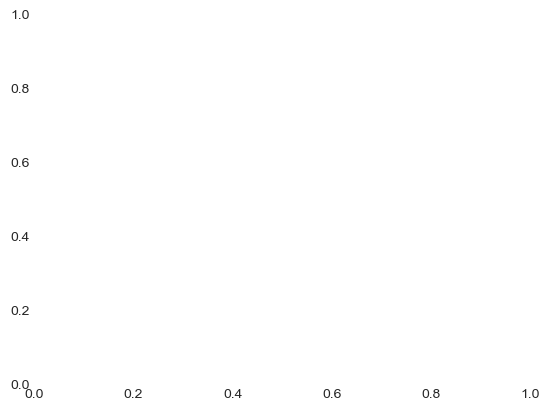

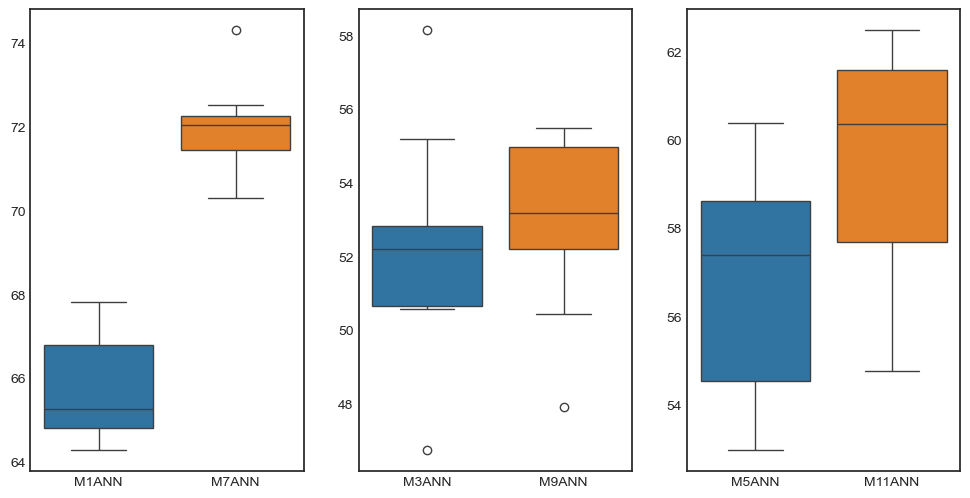

In [15]:
plt.style.use('seaborn-white')
plt.box(False)
fig, ax = plt.subplots(1,3, figsize=(12,6))
sns.boxplot(data=df[['M1ANN', 'M7ANN']]*100, ax=ax[0])
sns.boxplot(data=df[['M3ANN', 'M9ANN']]*100, ax=ax[1])
sns.boxplot(data=df[['M5ANN', 'M11ANN']]*100, ax=ax[2])
plt.savefig('plots/RQ3/boxplot_ann_oos.png')


C:\Users\berha\AppData\Local\Temp\ipykernel_22660\4272909017.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


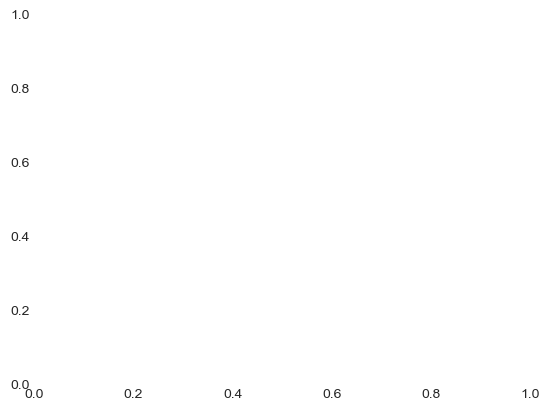

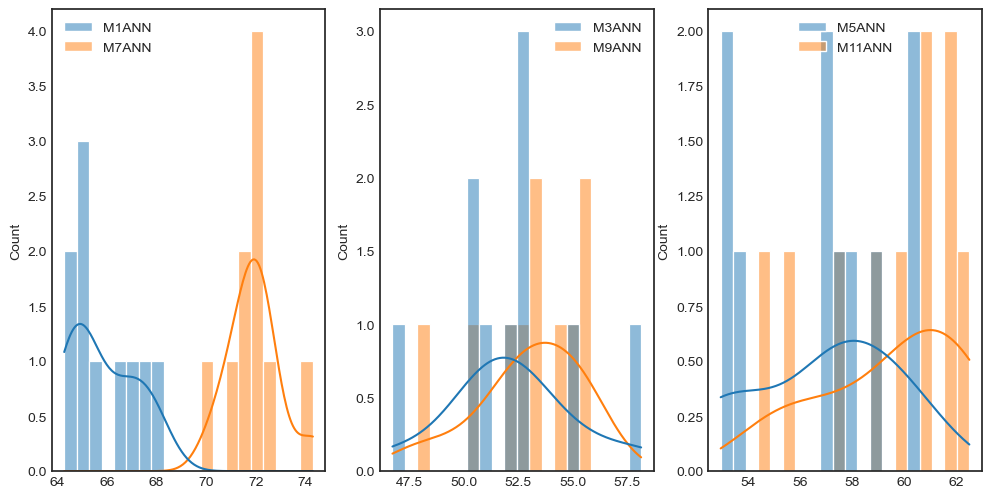

In [16]:
plt.style.use('seaborn-white')
plt.box(False)
fig, ax = plt.subplots(1,3, figsize=(12,6))
sns.histplot(data=df[['M1ANN', 'M7ANN']]*100, ax=ax[0],bins=20,kde=True)
sns.histplot(data=df[['M3ANN', 'M9ANN']]*100, ax=ax[1],bins=20,kde=True)
sns.histplot(data=df[['M5ANN', 'M11ANN']]*100, ax=ax[2],bins=20,kde=True)
plt.savefig('plots/RQ3/hist_ann_oos.png')
